## <span style="color:darkblue; font-weight:bold"> Analysis of variables (simulations without groups)</span>
- Explore data: relationships between "success" and each parameters; plot and explore interactions between parameters
- Check predictability (by RF and NN)

#### <span style="color:darkblue; font-weight:bold"> Load data</span>

In [1]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib import colors
from statistics import mean
import numpy as np

#NN
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## 90%
csv = pd.read_csv("../1_datasets/simcomms/simul_data_tomate_june14_full.csv", index_col="sample")
prefix = "90_"

## 50%
csv = pd.read_csv("../1_datasets/simcomms/processed_data_simcomms_0.5_full_jun16", index_col="sample")
prefix = "50_"

del csv["reached_fixation_at"]

csv = csv.dropna()

# substitute 1.00E+06 with 1000000
csv = csv.replace(to_replace="1.00E+06", value=100000)

# factorize distrib
csv.distrib = [1 if i=="uniform" else 0 for i in csv.distrib]

# filter by dilfactor
#csv = csv[csv.dilfactor < 0.01]

#csv.head()

2023-06-21 16:20:40.417345: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-21 16:20:40.459421: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-21 16:20:40.460083: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 16:20:41.148296: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## <span style="color:darkblue; font-weight:bold"> Plot effect of each variable 🚀 (simple plots) </span>

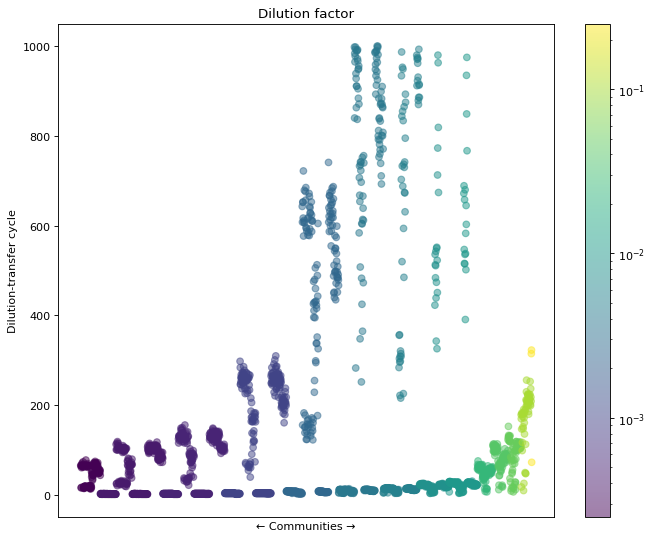

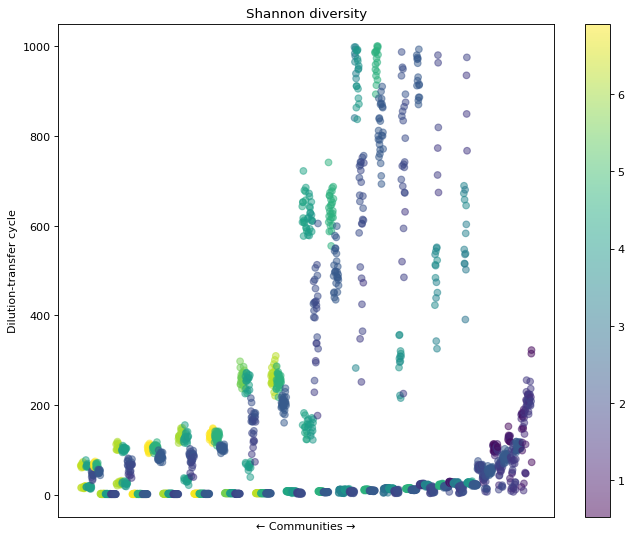

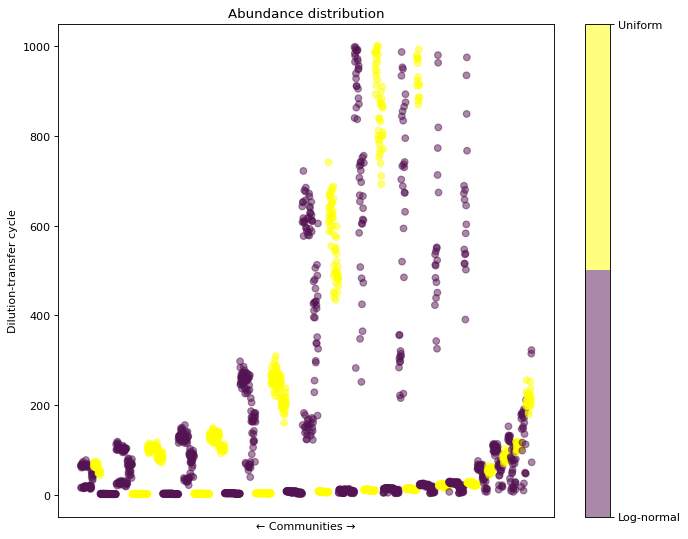

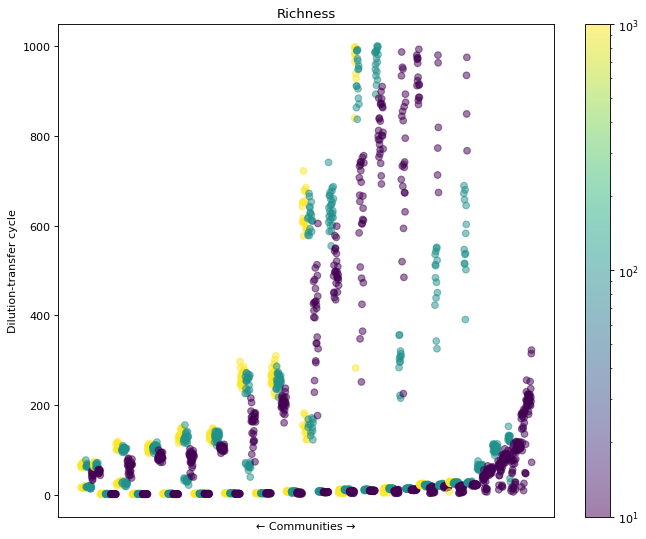

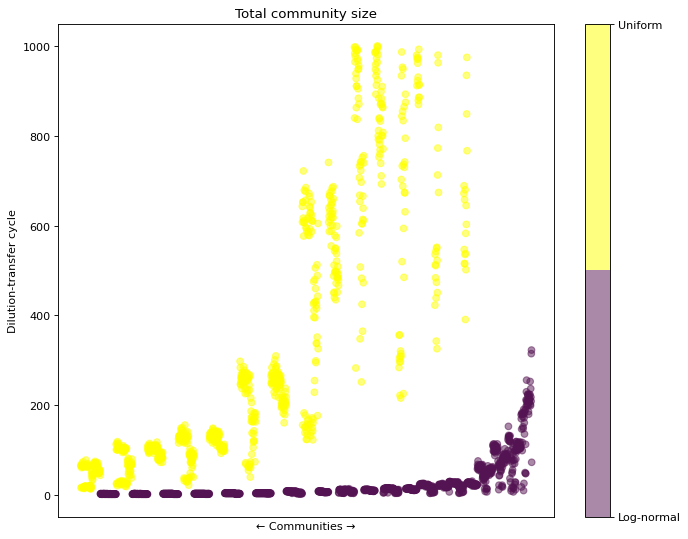

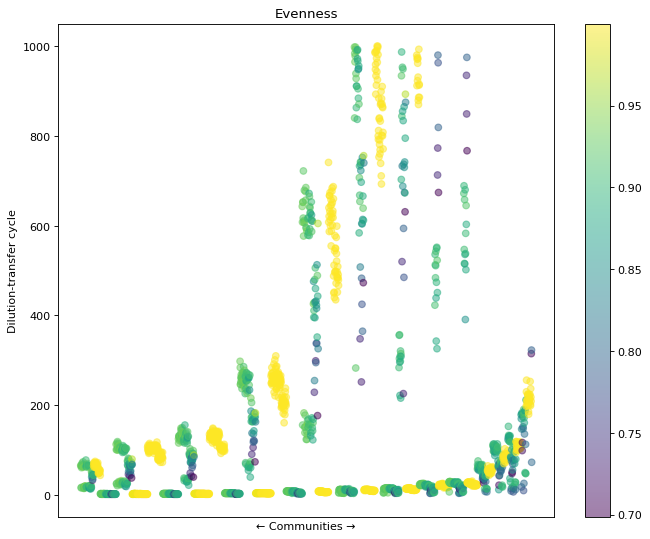

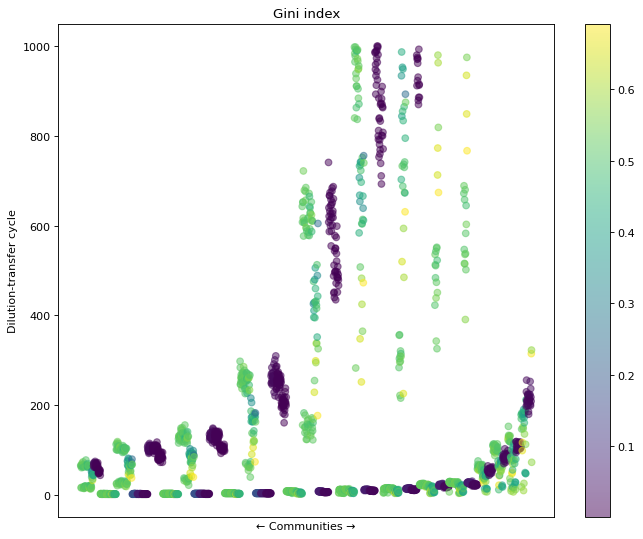

In [2]:
# Another simple plot is to put all y (real) values in a set order
csv2 = csv#[csv["dilfactor"]==0.04]

for n, i in enumerate(["dilfactor", "raw_shannon", "distrib", "richness", "size", "raw_even", "gini"]):
    name = ["Dilution factor", "Shannon diversity", "Abundance distribution", "Richness", "Total community size", "Evenness", "Gini index"][n]
    
    cmap = None
    mynorm = None
    ## Logarithmic color scale for these
    if i in ["richness", "dilfactor"]:
        mynorm = colors.LogNorm()
    ## Not a gradient needed for these
    if i in ["distrib", "size"]:
        cmap = colors.ListedColormap(["#541352FF", "yellow"])  # Binary colormap (viridis)
        bounds = [np.unique(csv2[i]).min(), np.unique(csv2[i]).max()]  # Boundaries for colormap
        
        plt.figure(figsize=(10, 8), dpi=80)
        plt.scatter(range(csv2.shape[0]),
                    csv2.success,
                    c=csv2[i],
                    cmap=cmap,
                    norm=None,
                    facecolors="none",
                    alpha=0.5)
        plt.title(name)
        cbar = plt.colorbar(ticks=bounds)
        cbar.ax.set_yticklabels(["Log-normal", "Uniform"])
    else:
        plt.figure(figsize=(10, 8), dpi=80)
        plt.scatter(range(csv2.shape[0]),
                    csv2.success,
                    c=csv2[i],
                    norm=mynorm,
                    facecolors="none",
                    alpha=0.5)
        plt.title(name)
        plt.colorbar()
    

    plt.title(name)
    plt.ylabel("Dilution-transfer cycle")
    plt.xticks([])
    plt.xlabel("← Communities →")
    plt.savefig(prefix + i + ".png")
    plt.show()
    plt.close()


#### <span style="color:darkblue; font-weight:bold"> Evaluation of suitability of dilution factors</span>

In [3]:
for fd in np.sort(np.unique(csv2.dilfactor)):
    successes = list(csv2.success[csv2.dilfactor==fd])
    print(fd, "-- total communities:", str(len(successes)), " -- mean:", str(round(np.mean(successes), 3)))

0.00025 -- total communities: 104  -- mean: 46.442
0.0004 -- total communities: 331  -- mean: 42.801
0.0005 -- total communities: 327  -- mean: 57.174
0.001 -- total communities: 326  -- mean: 112.675
0.0025 -- total communities: 277  -- mean: 244.058
0.004 -- total communities: 236  -- mean: 332.453
0.005 -- total communities: 192  -- mean: 193.875
0.008 -- total communities: 155  -- mean: 91.742
0.01 -- total communities: 151  -- mean: 97.503
0.025 -- total communities: 82  -- mean: 50.976
0.04 -- total communities: 80  -- mean: 81.7
0.05 -- total communities: 69  -- mean: 89.507
0.1 -- total communities: 54  -- mean: 174.722
0.25 -- total communities: 3  -- mean: 237.0


## <span style="color:darkblue; font-weight:bold"> Train RF model🚀</span>

In [27]:
csv2 = csv2[csv2.dilfactor <= 0.01] # filter by dilfactor

## Make one model first

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(csv2.drop(['success', 'transfer',
                                                             'filename', 'initial_size', 'final_size',
                                                             'filt_even', 'filt_shannon',
#                                                              'gini', 'raw_even',
#                                                              'richness',
#                                                               'distrib'
                                                             ], axis=1), csv2['success'], test_size=0.2)

# Create a random forest regressor with 1000 trees
rf = RandomForestRegressor(n_estimators=1000)


# Train the model on the entire training data
rf.fit(X_train, y_train)

# Predict the output variable for the test data
y_pred = rf.predict(X_test)

# Calculate the R² value to evaluate the model's performance
#r2_value = r2_score(y_test, y_pred)
#print("R² value:", r2_value)

In [28]:
## Get CV scores

# Perform cross-validation
cv_scores = cross_val_score(rf, X_train, y_train, cv=10, scoring='r2')

# Calculate the mean and standard deviation of the cross-validation scores
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)
print("Cross-Validation R² Score:", mean_cv_score)
print("Cross-Validation Standard Deviation:", std_cv_score)

Cross-Validation R² Score: 0.9290291405225511
Cross-Validation Standard Deviation: 0.02993410520579027


#### <span style="color:darkblue; font-weight:bold"> Check general predictability of the models</span>

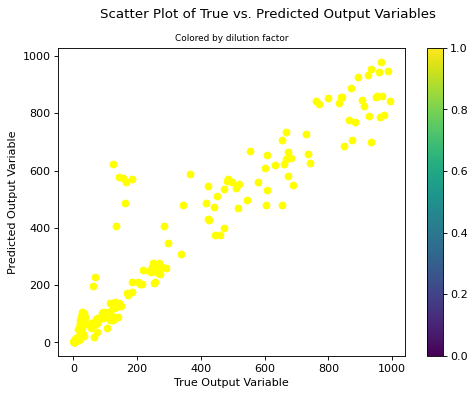

In [29]:
plt.figure(figsize=(7, 5), dpi=80)
# Create a scatter plot of the true output variable vs. the predicted output variable, colored by dilfactor
plt.scatter(y_test, y_pred, c=X_test['dilfactor'], norm=colors.LogNorm())
#plt.scatter(y_test[X_test.distrib==1], y_pred[X_test.distrib==1], c=X_test[X_test.distrib==1].distrib)
#plt.scatter(y_test[X_test.distrib==0], y_pred[X_test.distrib==0], c=X_test[X_test.distrib==0].distrib)


# Add a color bar to the plot to show the mapping between colors and input variable values
plt.colorbar()

# Add axis labels and a title to the plot
plt.xlabel('True Output Variable')
plt.ylabel('Predicted Output Variable')
plt.suptitle('Scatter Plot of True vs. Predicted Output Variables')
plt.title("Colored by dilution factor", size=8)

# Show the plot
plt.savefig(prefix + "scatter_plot.png")
plt.show()
plt.close()

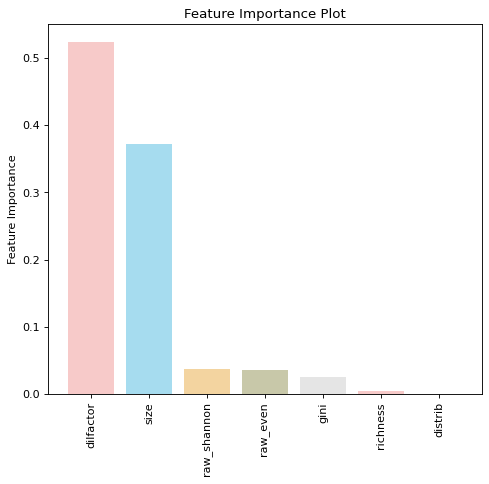

In [7]:
# Get the feature importances from the trained random forest model
importances = rf.feature_importances_

# Get the names of the input variables
feature_names = X_train.columns

# Sort the feature importances in descending order
indices = importances.argsort()[::-1]


# Define a list of colors for the bars
colorl = ['blue', 'green', 'orange', 'red', 'purple']
colorl = ['#f7cac9', '#a6dcef', '#f3d4a0', '#c8c8a9', '#e5e5e5']

# Create a bar plot of the feature importances
plt.figure(figsize=(7, 6), dpi=80)
plt.bar(range(X_train.shape[1]), importances[indices], color=colorl)

# Add axis labels and a title to the plot
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.ylabel('Feature Importance')
plt.title('Feature Importance Plot')

# Add axis labels and a title to the plot
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.ylabel('Feature Importance')
plt.title('Feature Importance Plot')


# Show the plot
plt.savefig(prefix + "feature_importance.png")
plt.show()
plt.close()

In [8]:
import eli5

# Compute the feature importances
eli5.show_weights(rf, feature_names=X_test.columns.tolist())

Weight,Feature
0.5238 ± 0.0313,dilfactor
0.3729 ± 0.0236,size
0.0370 ± 0.0197,raw_shannon
0.0357 ± 0.0207,raw_even
0.0253 ± 0.0226,gini
0.0053 ± 0.0106,richness
0.0001 ± 0.0008,distrib


#### <span style="color:darkblue; font-weight:bold"> Plot each variable's predictable effect using PDP </span>

**Super useful video** https://youtu.be/uQQa3wQgG_s

PDP stands for "Partial Dependence Plot", and it is a way to visualize the relationship between a feature and the target variable in a machine learning model while controlling for the effect of other features. It is a popular technique for interpreting black-box models, as it provides a way to see the effect of a single feature on the predicted outcome, while holding all other features constant.

> **Disadvantage**: it might simulate some "unreal" values. In the example in the video, the total played games (won games + lost games) was inconsistent. In our case, it's "making up" some values. For instance, with the "size" variable we only actually have 10000 and 1000000 values, but it's simulating many more.

**1D PDP plot**: This plot shows the marginal effect of a single feature on the predicted outcome, after accounting for the average effect of all other features. It does this by **fixing the values of all other features to their average value** and then varying the value of the feature of interest over a range of values. The resulting plot shows how the predicted outcome changes as the value of the feature of interest changes.

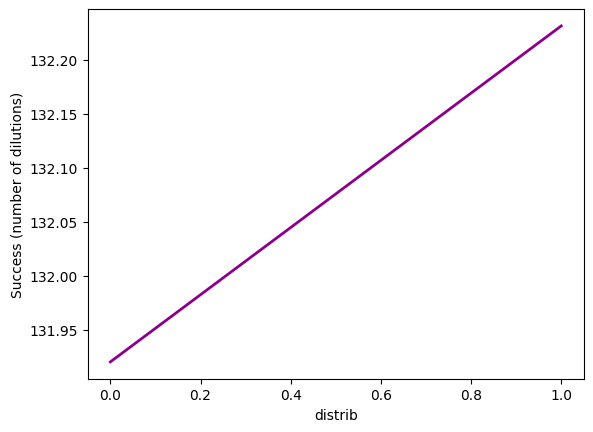

ValueError: The number of FixedLocator locations (0), usually from a call to set_ticks, does not match the number of labels (2).

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

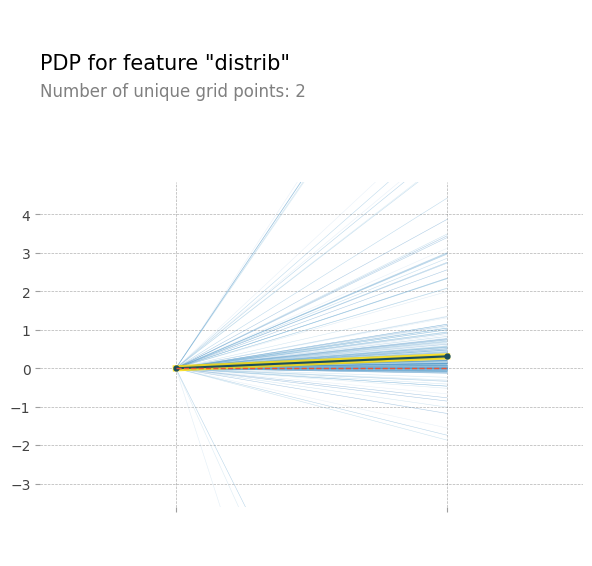

In [9]:
from pdpbox import pdp, get_dataset, info_plots
from pdpbox.pdp import pdp_isolate, pdp_plot


for i, feature_to_plot in enumerate(X_test.columns):
    pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_test, model_features=X_test.columns, feature=feature_to_plot)
    pdp_data = {'x': pdp_dist.feature_grids, 'y': pdp_dist.pdp}
    pdp_plot_data = pd.DataFrame(data=pdp_data)
    plt.plot(pdp_plot_data['x'], pdp_plot_data['y'], color='#8B008B', lw=2)
    plt.xlabel(feature_to_plot)
    plt.ylabel('Success (number of dilutions)')
    
    plt.show()

    # Save pdp_plot to a temporal PNG file
    pdp_plot_path = 'pdp_plot.png'
    pdp_plot, pdp_ax = pdp.pdp_plot(pdp_dist,
                                    feature_to_plot,
                                    plot_lines=True,
                                  #  frac_to_plot=100,
                                    plot_pts_dist=True,
                                    plot_params={'color': '#8B008B'},figsize=(7,7.1)
                                   )
    plt.show()


**2D PDP plot**: There are some approaches that can be used to visualize the relationships between **pairs of features** in the model, such as the individual conditional expectation (ICE) plots or the accumulated local effects (ALE) plots.

pdpbox does offer ICE plots via the pdp_interact_plot function, which allows you to create a 2D plot showing the variation in predicted outcomes for two features across different values of those features.

We use the pdp_interact_plot function here to take a look at interactions between the features.

Some notes for interpretation will be right behind the plots.

In [ ]:
from itertools import combinations

# Get the feature names from your dataset
feature_names = X_train.columns

# Create a list of all combinations of two features
feature_combinations = list(combinations(feature_names, 2))

# Loop through all feature combinations
for feature_combo in feature_combinations:
    try:
        # Extract the names of the two features
        feature1, feature2 = feature_combo

        # Create the PDP plot for the two features
        pdp_interact_out = pdp.pdp_interact(model=rf, dataset=X_train, model_features=feature_names, features=[feature1, feature2])
        fig, axes = pdp.pdp_interact_plot(pdp_interact_out, feature_names=[feature1, feature2])
        plt.show()
    except:
        print(str(feature_combo) + " failed")

##### **Interpretation: island**
If there is an "island" of yellow color in the middle of the plot, it means that there is a specific combination of feature values where the interaction effect is strongest. This is often referred to as a "hotspot" or a "sweet spot"
--> **En esas zonas, el éxito tarda más, así que en nuestro caso es algo "malo"**

##### **Interpretation: colors**
The color gradient on the pdp_interact_plot() indicates the **effect of the interaction between the two features on the predicted outcome**.

Darker colors indicate a larger effect of the interaction on the predicted outcome, while lighter colors indicate a smaller effect (see super useful example: https://scikit-learn.org/stable/modules/partial_dependence.html). The numerical values and the colors also **indicate the value of the predicted value directly**, so when we see a color closer to purple we are actually seeing earlier success. In other words, the color scale shows the range of predicted outcome changes resulting from the interaction between the two features.

_The strength of the interaction, on the other hand, refers to how much the effect of one feature on the outcome changes as the value of the other feature changes. It is not directly related to the color gradient on the plot._ --> I'm guessing - since two features can actually be related but if it doesn't affect the Y outcome it doesn't matter to us, and we will not be able to see it here.

##### **Interpretation: parallel lines**
If you get **parallel lines** in one of the PDP interaction plots, it suggests that there is no interaction between those two features. In other words, the effect of one feature on the target variable is not affected by the values of the other feature.

For example, if you have a PDP interaction plot for the features "dilfactor" and "richness" and you see parallel lines, it means that the effect of dilfactor on the target variable (success) is not affected by gender. **This could suggest that dilfactor and richness are not strongly correlated** with each other and that they have independent effects on the target variable.

However, it is important to note that parallel lines in a PDP interaction plot **do not necessarily mean that the two features are not related** or that they have no impact on the target variable. **It just means that their effects are independent** of each other.

##### **Interpretation: pointed area**

If you see vertical lines that are parallel for the most part but have a pointed area (like with **size and raw_shannon**), it suggests that there is a significant interaction effect between the two features being plotted. In other words, the effect of one feature on the target variable changes depending on the value of the other feature.

- The **pointed area** represents the region where the interaction effect occurs. In that region, the partial dependence of the target variable on one feature changes rapidly as the other feature changes.

- The fact that the pointed area occurs for all values of size suggests that **this is not simply a result of a single outlier** or extreme value in the data. Instead, it may be that there is some threshold or nonlinear relationship between raw_shannon and another feature that is being picked up in this plot.

- When the **vertical line is pointed at a specific value of Y**, it means that the interaction effect between the two features (in this case, raw_shannon and size) **is strongest at that value of Y**. In other words, when raw_shannon takes on a value of 2 or lower, size has a greater impact on the predicted outcome.

#### <span style="color:darkblue; font-weight:bold"> Plot effect of each variable 🚀 using SHAP </span>

The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. The SHAP explanation method computes Shapley values from coalitional game theory. The feature values of a data instance act as players in a coalition. Shapley values tell us how to fairly distribute the “payout” (= the prediction) among the features. **One innovation that SHAP brings to the table is that the Shapley value explanation is represented as an additive feature attribution method, a linear model**.

Lundberg et al. (2018)70 proposed TreeSHAP, a variant of SHAP **for tree-based** machine learning models such as decision trees, random forests and gradient boosted trees.

TreeSHAP defines the value function using the conditional expectation EXj|X−j(^f(x)|xj)
instead of the marginal expectation. The problem with the conditional expectation is that **features that have no influence on the prediction function f can get a TreeSHAP estimate different from zero**. The non-zero estimate can happen when the feature is correlated with another feature that actually has an influence on the prediction.

https://christophm.github.io/interpretable-ml-book/shap.html#treeshap

In [ ]:
import shap

# Compute the SHAP values for the test data
explainer = shap.Explainer(rf, X_train, algorithm="tree")
shap_values = explainer(X_test,  check_additivity=False ) # TODO

# Plot the Shapley values for a specific instance
shap.plots.waterfall(shap_values[0])